# Osadzanie słów

Kolejnym popularnym sposobem łączenia wektora ze słowem jest zastosowanie gęstych wektorów słów, określanych również mianem osadzeń słów (ang. word embeddings). Wektory uzyskane przy użyciu techniki kodowania z gorącą jedynką są binarne, rzadkie (zawierają głównie zera) i wysokowymiarowe (liczba ich wymiarów jest równa liczbie słów wchodzących w skład słownika). Osadzenia słów charakteryzują się niską liczbą wymiarów. Są to gęste wektory zmiennoprzecinkowe. Osadzenia słów, w przeciwieństwie do wektorów uzyskanych za pomocą techniki kodowania z gorącą jedynką, są uczone z danych. Osadzenia słów mają zwykle 256, 512 wymiarów, a w przypadku pracy z bardzo dużymi słownikami nawet 1024 wymiary. Praca z wektorami słów zakodowanymi metodą gorącej jedynki zwykle prowadzi do wygenerowania wektorów mających 20 000 lub więcej wymiarów (wektor mający 20 000 wymiarów może być użyty do zakodowania 20 000 tokenów). Jak widać, osadzenia słów pozwalają zakodować więcej informacji w mniejszej liczbie wymiarów.

![word embeddings vs. one hot encoding](img\6_1_2.png)

Osadzenia słów można tworzyć na dwa sposoby:

* Mogą one być uczone wraz z głównym zadaniem (np. klasyfikacją dokumentu lub przewidywaniem sentymentu). W takim przypadku pracę zaczyna się od losowych wektorów słów, a następnie zawartość tych wektorów jest uczona w taki sam sposób jak wagi sieci neuronowej.
* Do modelu można załadować osadzenia słów utworzone podczas pracy nad innym problemem uczenia maszynowego. Takie osadzenia określamy mianem uprzednio wytrenowanych osadzeń słów.

Przyjrzyjmy się obu rozwiązaniom.

## Uczenie osadzeń słów przy użyciu warstwy osadzającej


Najprostszym sposobem powiązania gęstego wektora ze słowem jest wybranie losowego wektora. Problemem z takim rozwiązanie jest to, że wynikowa przestrzeń osadzeń nie ma struktury — np. słowa piękny i śliczny mogą skończyć w zupełnie różnych osadzeniach pomimo tego, że w większości zdań są to synonimy. Sieć neuronowa może mieć problem z uporządkowaniem tak zaszumianej i pozbawionej struktury przestrzeni osadzeń.

Przejdźmy na poziom pewnej abstrakcji. Geometryczna zależność między wektorami słów powinna odzwierciedlać semantyczną zależność między tymi słowami. Osadzenia słów mają odzwierciedlać język w przestrzeni geometrycznej. W poprawnej przestrzeni osadzeń synonimy powinny być osadzone w podobnych wektorach słów. Ogólnie rzecz biorąc, odległość geometryczna (np. odległość L2) między dowolnymi dwoma słowami powinna odzwierciedlać różnicę semantyczną między nimi. W przestrzeni osadzeń nie tylko odległość ma znaczenie — również kierunki powinny mieć określone znaczenie. Wyjaśnijmy to na konkretnym przykładzie.

[...]


W rzeczywistości przestrzenie osadzania pozwalają na wykonanie transformacji zmieniających płeć lub uzyskanie liczby mnogiej. Dodając wektor „rodzaju żeńskiego” do wektora „król”, uzyskamy wektor „królowa”. Dodając do wektora „król” wektor „liczba mnoga”, uzyskamy wektor „królowie”. Przestrzenie osadzeń słów zwykle zawierają tysiące wektorów, które można zinterpretować i z których można potencjalnie skorzystać.

Czy istnieje doskonała przestrzeń osadzania słów, która idealnie oddałaby zależności między słowami używanymi przez ludzi? Być może, ale nikt jej jeszcze nie uzyskał. Nie ma czegoś takiego jak język ludzki — ludzie posługują się wieloma różnymi językami, które nie są izometryczne (język stanowi odzwierciedlenie kultury i określonego kontekstu). W praktyce to, czy dana przestrzeń osadzeń jest dobra, zależy głównie od problemu, który chcemy rozwiązać. Idealna przestrzeń osadzeń słów języka angielskiego modelu analizy sentymentu recenzji filmów wygląda inaczej od idealnej przestrzeni osadzeń słów języka angielskiego modelu klasyfikującego dokumenty prawne. Wynika to z tego, że w każdym z tych problemów ważne są inne zależności semantyczne.

W związku z tym warto trenować nową przestrzeń osadzeń przy okazji rozwiązywania nowego problemu. Na szczęście proces ten ułatwia algorytm propagacji wstecznej oraz pakiet Keras. Wszystko sprowadza się do wyuczenia wartości wag warstwy osadzania Embedding.

In [1]:
from keras.layers import Embedding

# Warstwa Embedding przyjmuje przynajmniej dwa argumenty:
# liczbę tokenów (tutaj 1000: 1 + maksymalny indeks słowa)
# i liczbę wymiarów osadzeń (tutaj 64).
embedding_layer = Embedding(1000, 64)

2025-04-27 12:02:28.798399: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 12:02:28.809162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745748148.822706    1498 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745748148.826922    1498 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 12:02:28.842851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr


Warstwę Embedding najlepiej jest rozumieć jako słownik mapujący całkowitoliczbowe indeksy oznaczające określone słowa na gęste wektory. Przyjmuje ona na wejściu wartości całkowitoliczbowe i wyszukuje je w wewnętrznym słowniku, zwracając związane z nimi wektory.


Warstwa Embedding przyjmuje na wejściu dwuwymiarowy tensor o kształcie (próbki, długość_sekwencji). Każdy element tego tensora jest sekwencją liczb całkowitych. Warstwa ta może osadzać sekwencje o zmiennej długości: do zaprezentowanej w poprzednim przykładzie warstwy Embedding możliwe jest kierowanie wsadów o kształcie (32, 10) (32 sekwencje o długości równej 10) lub wsadów o kształcie (64, 15) (wsad 64 sekwencji o długości 15). Wszystkie sekwencje wchodzące w skład wsadu muszą mieć tę samą długość (wynika to z faktu umieszczania ich w tym samym tensorze), a więc sekwencje, które są krótsze od innych, należy dopełnić zerami, a sekwencje, które są dłuższe, należy uciąć.

Warstwa ta zwraca trójwymiarowy tensor zmiennoprzecinkowy o kształcie (próbki, długość_sekwencji, liczba_wymiarów_osadzenia). Taki trójwymiarowy tensor może zostać przetworzony przez warstwę RNN lub jednowymiarową warstwę konwolucyjną (oba rozwiązania opiszę w kolejnych sekcjach).

Podczas tworzenia instancji warstwy Embedding jej wagi (wewnętrzny słownik wektorów tokenów) są inicjowane losowo (tak jak w przypadku każdej innej warstwy). Podczas trenowania wektory słów są stopniowo dostrajane przy użyciu algorytmu propagacji wstecznej, co prowadzi do uzyskania przestrzeni, z której może korzystać model. Po pełnym wytrenowaniu przestrzeń osadzeń będzie miała charakter struktury wyspecjalizowanej pod kątem rozwiązywania problemu, do którego trenowany jest model.

Zastosujmy to rozwiązanie w modelu przewidującym sentyment recenzji filmu wchodzącej w skład zbioru IMDB (z zadaniem tym próbowaliśmy się zmierzyć już wcześniej). Zacznijmy od szybkiego przygotowania danych. Ograniczymy zawartość recenzji do 10 000 najczęściej pojawiających się w nich słów (zabieg taki stosowaliśmy również podczas pierwszego podejścia do tego problemu), a następnie utniemy recenzje po zaledwie 20 słowach. Sieć będzie uczyć się ośmiowymiarowych osadzeń każdego z 10 000 słów, zamieni wejściową sekwencję wartości całkowitoliczbowych (dwuwymiarowy tensor całkowitoliczbowy) na sekwencje osadzone (trójwymiarowy tensor zmiennoprzecinkowy), spłaszczy ten tensor do dwóch wymiarów i wytrenuje pojedynczą warstwę Dense znajdującą się na końcu klasyfikatora.

In [2]:
from keras.datasets import imdb
from keras import preprocessing

# Liczba słów analizowanych w charakterze wag.
max_features = 10000
# Ucina recenzje, w których występuje ta liczba słów
# (słów zaliczanych do zbioru max_features najczęściej występujących słów).
maxlen = 20

# Ładuje dane w formie list wartości całkowitoliczbowych.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Zamieniamy listy liczb całkowitych na dwuwymiarowy tensor
# wartości całkowitoliczbowych o kształcie (próbki, maxlen).
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [7]:
x_train.shape, y_train.shape

((25000, 20), (25000,))

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Input

model = Sequential()
# Określamy maksymalną długość danych wejściowych warstwy Embedding,
# co umożliwi późniejsze spłaszczenie osadzonych danych wejściowych.
model.add(Input(shape=(maxlen,)))
model.add(Embedding(10000, 8, input_length=maxlen))
# Po przetworzeniu przez warstwę osadzania aktywacje mają kształt (próbki, maxlen, 8).

# Spłaszczanie trójwymiarowego tensora osadzeń
# w celu uzyskania dwuwymiarowego tensora o kształcie (próbki, maxlen * 8).
model.add(Flatten())

# Dodawanie ostatniej warstwy klasyfikatora.
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

/SI/si/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 20, 8)          │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,161 (313.13 KB)

 Trainable params: 80,161 (313.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.5641 - loss: 0.6840 - val_acc: 0.7030 - val_loss: 0.6065
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7434 - loss: 0.5596 - val_acc: 0.7354 - val_loss: 0.5201
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7879 - loss: 0.4648 - val_acc: 0.7470 - val_loss: 0.4991
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8023 - loss: 0.4302 - val_acc: 0.7518 - val_loss: 0.4950
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8218 - loss: 0.3992 - val_acc: 0.7540 - val_loss: 0.4944
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.8376 - loss: 0.3764 - val_acc: 0.7582 - val_loss: 0.4952
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8418 - loss: 0.3584 - val_acc: 0.7570 - val_loss: 0.5006
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8499 - loss: 0.3472 - val_acc: 0.7564 - val_loss: 0.5064
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - ac

Podczas walidacji uzyskujemy dokładność na poziomie ~76%. Jest to wynik dość dobry, biorąc pod uwagę to, że analizujemy tylko 20 pierwszych słów każdej recenzji. Zwróć uwagę na to, że spłaszczenie osadzonych sekwencji i trenowanie jednej górnej warstwy Dense prowadzi do uzyskania modelu traktującego niezależnie każde słowo sekwencji wejściowej. Model nie analizuje zależności między słowami i struktury zdania (potraktuje np. zdania this movie is a bomb i this movie is the bomb jako należące do recenzji negatywnych). O wiele lepszym rozwiązaniem jest dodanie do osadzonej sekwencji rekurencyjnych warstw lub jednowymiarowych warstw konwolucyjnych — pozwoli to na uczenie się cech biorących pod uwagę całość sekwencji. Rozwiązania te opiszę w kolejnych sekcjach.

## Używanie trenowanych wcześniej osadzeń słów


Czasami dysponuje się tak małą ilością dostępnych danych, że niemożliwe jest korzystanie z samych tych danych w celu wytrenowania osadzenia słów właściwego dla problemu. Co można zrobić w takiej sytuacji?

Zamiast trenować osadzenia słów łącznie z rozwiązywanym problemem, można w takim przypadku załadować osadzające wektory z utworzonej wcześniej przestrzeni osadzania, o której wiadomo, że ma odpowiednią strukturę i właściwości — ujmuje ogólne aspekty struktury języka. Sens używania wytrenowanych wcześniej osadzeń słów podczas przetwarzania języka naturalnego jest taki sam jak sens używania wytrenowanych wcześniej konwolucyjnych sieci neuronowych podczas klasyfikacji obrazów — jeżeli nie dysponujemy wystarczającą ilością danych, aby model mógł wytrenować samodzielnie praktyczne cechy, a cechy, których wytrenowania oczekujemy, mają charakter ogólny, to w przypadku cech wizualnych i semantycznych możemy używać cech wyuczonych przez modele pracujące nad innymi problemami.

Tego typu osadzenia słów tworzy się zwykle, korzystając ze statystyk występowania słów (obserwacji tego, jakie słowa występują obok siebie w zdaniach lub dokumentach). Robi się to za pomocą wielu technik. Niektóre z nich są oparte na sieciach neuronowych. Pomysł tworzenia gęstej niskowymiarowej osadzającej przestrzeni słów tworzonej w sposób nienadzorowany był początkowo analizowany przez Bengio i innych na początku lat dwutysięcznych , ale zyskał popularność w zastosowaniach praktycznych dopiero po opublikowaniu najsłynniejszego algorytmu osadzania słów — algorytmu Word2vec (https://code.google.com/archive/p/word2vec). Algorytm ten został opracowany w 2013 r. przez pracownika firmy Google Tomasa Mikolova. Wymiary algorytmu Word2vec odzwierciedlają określone właściwości semantyczne, takie jak rodzaj (płeć).

Istnieje wiele gotowych baz osadzeń słów, które można pobrać i zaimportować do warstwy Embedding pakietu Keras. Jednym z takich rozwiązań jest właśnie Word2vec. Innym popularnym projektem jest Global Vectors for Word Representation (GloVe): https://nlp.stanford.edu/projects/glove. Projekt ten został opracowany w 2014 r. przez badaczy z Uniwersytetu Stanforda. Ta technika osadzania korzysta z faktoryzacji macierzy wartości statystycznych określających wspólne występowanie słów. Jej autorzy udostępnili gotowe osadzenia milionów angielskich słów utworzone na podstawie danych z serwisów Wikipedia i Common Crawl.

Przyjrzyjmy się stosowaniu osadzeń GloVe w modelach Keras. W takim sam sposób można korzystać z osadzeń Word2vec i innych baz osadzeń słów. Pracując nad tym przykładem, przypomnimy również sobie opisane wcześniej techniki tokenizacji tekstu — pracę zaczniemy od surowego tekstu.

## Łączenie wszystkich technik: od surowego tekstu do osadzenia słów


Będziemy korzystać z modelu podobnego do tego, który został przed chwilą opisany — zamienimy zdania na sekwencje wektorów, spłaszczymy je i będziemy trenować górną warstwę Dense naszego modelu. Tym razem będziemy jednak korzystać z gotowych osadzeń słów. Zamiast wykorzystywać poddane tokenizacji dane zbioru IMDB dołączonego do pakietu Keras, zaczniemy od podstaw — pobierzemy dane w postaci surowego tekstu.

### Pobieranie danych zbioru IMDB w postaci surowego tekstu


Na początku musimy wejść na stronę  `http://ai.stanford.edu/~amaas/data/sentiment/` pobrać archiwum z surowym zbiorem danych IMDB i je rozpakować.

Następnie należy zebrać poszczególne recenzje tworzące treningowy zbiór danych i przedstawić je w formie listy łańcuchów — każda recenzja powinna tworzyć oddzielny łańcuch. Etykiety recenzji (określenia ich tonu) umieścimy na liście labels.

In [59]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenizacja danych


Dokonajmy konwersji danych tekstowych na wektory i przygotujmy zbiór treningowy i zbiór walidacyjny, korzystając z przedstawionych wcześniej koncepcji. Trenowane wcześniej osadzenia słów są szczególnie przydatne podczas pracy, gdy ma się dostęp do małej ilości danych treningowych (w przeciwnym razie osadzenia zoptymalizowane pod kątem danego problemu sprawdzą się o wiele lepiej), a więc ograniczmy treningowy zbiór danych do 200 pierwszych próbek. Będziemy trenować klasyfikator recenzji filmów na zaledwie 200 przykładach.


In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 150  # Skraca recenzję do 100 słów.
training_samples = 200  # Trenowanie na 200 próbkach.
validation_samples = 10000  # Walidacja na 10 000 próbek.
max_words = 10000  # Bierzemy pod uwagę tylko 10 000 słów najczęściej występujących w zbiorze.

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Znaleziono %s unikatowych tokenów.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Kształt tensora danych:', data.shape)
print('Kształt tensora etykiet:', labels.shape)


# Dzieli dane na zbiór treningowy i zbiór walidacyjny,
# ale najpierw dane są ustawiane w losowej kolejności
# (obecnie próbki są ustawione w kolejności od recenzji negatywnych do recenzji pozytywnych).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Znaleziono 88582 unikatowych tokenów.
Kształt tensora danych: (25000, 150)
Kształt tensora etykiet: (25000,)


### Pobieranie osadzeń słów GloVe


Ze strony https://nlp.stanford.edu/projects/glove możemy pobrać gotowe osadzenia słów wygenerowane w 2014 r. na podstawie artykułów w serwisie Wikipedia. Jest to archiwum ZIP zajmujące 822 MB (plik glove.6B.zip). Zawiera ono stuwymiarowe wektory osadzeń 400 000 słów (można je już określać mianem tokenów). Rozpakujmy to archiwum.

### Wstępne przetwarzanie osadzeń


Przeprowadźmy operację parsowania rozpakowanego pliku tekstowego w celu zbudowania indeksu przypisującego słowa (w formie łańcuchów) do reprezentacji wektorowych (wektorów liczb).

In [61]:
glove_dir = 'glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Znaleziono %s wektorów słów.' % len(embeddings_index))

Znaleziono 400000 wektorów słów.



Następnie będziemy budować macierz osadzeń, którą można załadować do warstwy Embedding. Macierz ta musi mieć kształt (max_words, embedding_dim), a element i ma zawierać wektor embedding_dim-wymiarowy dla słowa o indeksie i zbudowanym podczas tokenizacji. Zwrócimy uwagę na to, że indeks 0 nie ma odpowiadać żadnemu słowu ani tokenowi — jest to po prostu wypełniacz miejsca.

In [62]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Słowa nieznalezione w osadzanym indeksie zostaną zastąpione zerami.
            embedding_matrix[i] = embedding_vector

### Definiowanie modelu

Będziemy korzystać z tej samej architektury co we wcześniejszym modelu.:

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input, Dropout

model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(max_words, embedding_dim))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 15000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │       480,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,480,065 (5.65 MB)

 Trainable params: 1,480,065 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

### Ładowanie osadzeń GloVe do modelu


Warstwa Embedding ma pojedynczą macierz wag: dwuwymiarową macierz wartości zmiennoprzecinkowych, w której każdy element i jest wektorem słowa skojarzonym z indeksem i. Musimy po prostu załadować przygotowaną macierz GloVe do warstwy Embedding, będącej pierwszą warstwą modelu:

In [80]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Dodatkowo zamrozimy warstwę Embedding (przypiszemy wartość False do jej atrybutu trainable). Sensowność tego rozwiązania wyjaśniałem już przy okazji korzystania z wytrenowanych wcześniej cech konwolucyjnych sieci neuronowych — gdy niektóre elementy modelu (takie jak warstwa Embedding) zostały wytrenowane wcześniej, a inne elementy (takie jak klasyfikator) są inicjowane liczbami losowymi, nie powinno dochodzić do modyfikowania wytrenowanych wcześniej elementów modelu, ponieważ doprowadzi to do zniknięcia zapisanej w nich wiedzy. Duże wartości aktualizacji gradientu wywołane losowym charakterem niektórych elementów modelu spowodują wprowadzenie dużych zmian w wytrenowanych cechach.

### Trenowanie i ewaluacja modelu

Skompilujmy model i go wytrenujmy:

In [81]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.weights.h5')

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - acc: 0.5781 - loss: 0.7382 - val_acc: 0.5104 - val_loss: 0.7132
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - acc: 0.5351 - loss: 0.7128 - val_acc: 0.5089 - val_loss: 0.7144
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - acc: 0.5944 - loss: 0.6976 - val_acc: 0.5114 - val_loss: 0.7120
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - acc: 0.5659 - loss: 0.7072 - val_acc: 0.5080 - val_loss: 0.7170
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - acc: 0.5112 - loss: 0.7318 - val_acc: 0.5086 - val_loss: 0.7148
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - acc: 0.5772 - loss: 0.6958 - val_acc: 0.5109 - val_loss: 0.7115
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - acc: 0.5383 - loss: 0.6819 - val_acc: 0.5090 - val_loss: 0.7150
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - acc: 0.6483 - loss: 0.6399 - val_acc: 0.5085 - val_loss: 0.7121
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - acc: 0.6270 - loss: 

Teraz możemy wygenerować wykresy ilustrujące zmiany wydajności modelu na przestrzeni czasu:

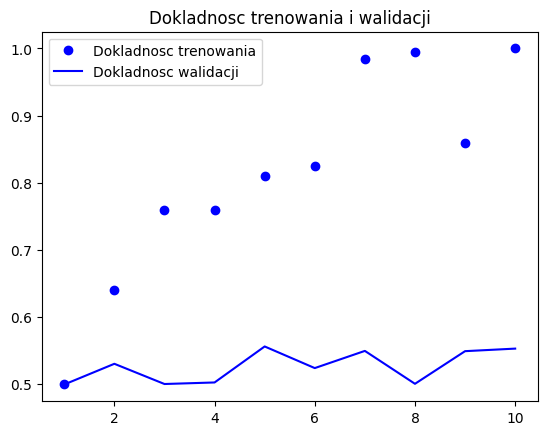

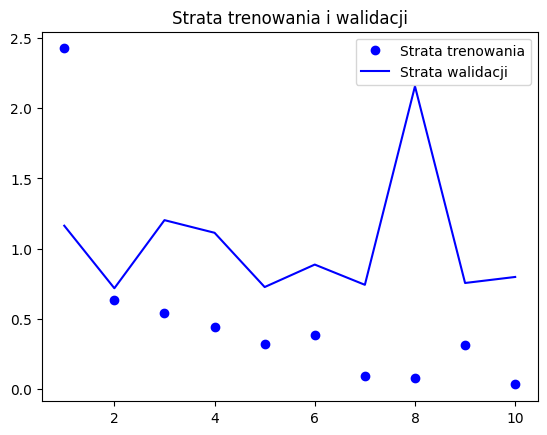

In [56]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

Model zaczyna szybko ulegać nadmiernemu dopasowaniu, co nie jest niczym zaskakującym przy tak małej liczbie próbek wchodzących w skład treningowego zbioru danych. Z tego samego powodu dokładność walidacji charakteryzuje się dużą zmiennością, ale wydaje się uzyskiwać szczytową wartość na poziomie przekraczającym 50%.

Przy tak małej liczbie próbek wchodzących w skład treningowego zbioru danych charakterystyka modelu w dużej mierze zależy od tego, które 200 próbek zostanie wybranych do treningowego zbioru danych (próbki te są wybierane w sposób losowy). Jeżeli Twój model uzyskuje wyraźnie gorsze parametry, to spróbuj wylosować inny zestaw 200 próbek (to tylko ćwiczenie, podczas pracy nad prawdziwym problemem nie dysponuje się możliwością wybrania danych treningowych).

Możemy również wytrenować ten sam model bez ładowania wytrenowanych osadzeń słów i bez zamrażania warstwy osadzeń. W takim przypadku model będzie trenować osadzenia tokenów wejściowych właściwe dla naszego problemu. Rozwiązanie to, ogólnie rzecz biorąc, sprawdza się o wiele lepiej od stosowania gotowych osadzeń słów w przypadku problemów, w których dysponuje się obszernym zbiorem danych. Dysponujemy zbiorem tylko 200 próbek treningowych, ale pomimo to wypróbujmy to rozwiązanie.

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(max_words, embedding_dim))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 15000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │       480,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,480,065 (5.65 MB)

 Trainable params: 1,480,065 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - acc: 0.5146 - loss: 0.6933 - val_acc: 0.5065 - val_loss: 0.6940
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - acc: 0.9214 - loss: 0.5394 - val_acc: 0.5147 - val_loss: 0.6961
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - acc: 0.9531 - loss: 0.3667 - val_acc: 0.5279 - val_loss: 0.6960
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - acc: 1.0000 - loss: 0.1695 - val_acc: 0.5072 - val_loss: 0.7412
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - acc: 1.0000 - loss: 0.0923 - val_acc: 0.5218 - val_loss: 0.7089
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - acc: 1.0000 - loss: 0.0524 - val_acc: 0.5223 - val_loss: 0.7197
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - acc: 1.0000 - loss: 0.0300 - val_acc: 0.5188 - val_loss: 0.7360
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - acc: 1.0000 - loss: 0.0190 - val_acc: 0.5219 - val_loss: 0.7286
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - acc: 1.0000 - loss: 

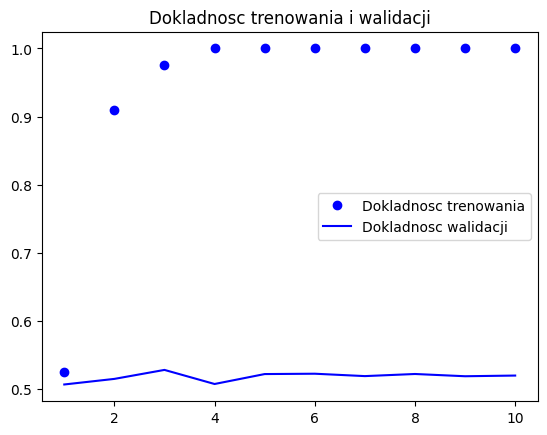

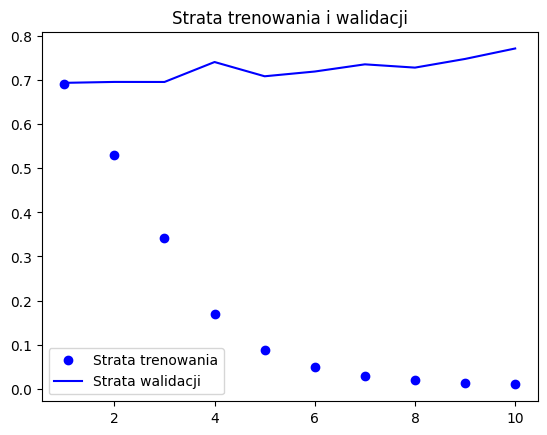

In [93]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()


Dokładność walidacji utrzymuje się na poziomie zbliżonym do 50%. W tym przypadku korzystanie z gotowych osadzeń słów pozwoliło na uzyskanie lepszych wyników. Jeżeli zwiększymy liczbę próbek wchodzących w skład treningowego zbioru danych dość szybko uzyskamy lepszą wydajność od tej, którą uzyskaliśmy, korzystając z gotowych osadzeń słów. Spróbuj zrobić to samodzielnie w ramach ćwiczeń.

Na koniec możemy sprawdzić wydajność modelu podczas przetwarzania danych testowych. W tym celu musimy zamienić dane testowe na tokeny:

In [57]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Teraz możemy załadować pierwszy model i ocenić efekty jego pracy:

In [82]:
model.load_weights('pre_trained_glove_model.weights.h5')
model.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.6956 - loss: 0.6115


[0.7185472846031189, 0.5108799934387207]

Uzyskujemy dokładność testową na poziomie 56%. Praca z małą liczbą próbek treningowych jest naprawdę trudna!

Komentarze Jakuba:
Musiałem zmienić wynieść kształt wejścia jako osobną warstwę Input, w innym przypadku kod nie działał poprawnie i zwracał sam None type z zerowymi parametrami w summary.

Dodanie warstwy dropout i zmienienie maxlen (długości recenzji) na 150 do pierwszego modelu pomogło lekko podnieść wyniki walidacji, ale niewiele, i chyba nie wpłynęło na wyniki testu. Następnie wskazałem learning_rate w rmsprop na 1e-4 i to niewiele podniosło dokładność w walidacji, ale zapewniło większą stabilność loss w walidacji (wcześniej skakało nawet na ponad 2), oraz podniosło znacznie dokładność testu (z 56% na 69%).
Próbowałem jeszcze dodstosować parametry drugiego modelu, ale nie udało mi się poprawić w nim wyników. Poza zmianami z pierwszego modelu, próbowałem też zmniejszyć embedding_dim. Zmiany powodowały podobne wyniki, ale bez zmian te wyniki pojawiały się wcześniej w procesie uczenia.